In [37]:
import numpy as np
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical

from tqdm import tqdm

import matplotlib.pyplot as plt

import env


In [38]:
cuda = False

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Actor Critic on LunarLander enviorment

In [56]:
class Actor(nn.Module):
    def __init__(self):
        super(Actor, self).__init__()
        self.linear1 = nn.Linear(8, 128)
        self.linear2 = nn.Linear(128, 4)

    def forward(self, state):
        if cuda == False: 
            state = torch.from_numpy(state).float()
        output_1 = F.relu(self.linear1(state))
        output_2 = self.linear2(output_1)

        distribution = Categorical(F.softmax(output_2, dim=-1))

        return output_1, distribution

class Critic(nn.Module):
    def __init__(self, ):
        super(Critic, self).__init__()
        self.linear1 = nn.Linear(128, 1)

    def forward(self, state):
        value = self.linear1(state)

        return value

class ActorCritic(nn.Module):
    def __init__(self, actor, critic):
        super(ActorCritic, self).__init__()
        self.actor = actor
        self.critic = critic

        self.logprobs = []
        self.state_values = []
        self.rewards = []

    def forward(self, state):
        state, distribution = self.actor(state)
        action = distribution.sample()
        
        state_value = self.critic(state)
        
        self.logprobs.append(distribution.log_prob(action))
        self.state_values.append(state_value)
        
        return action.item()
    
    def calculateLoss(self, gamma=0.99):
        # calculating discounted rewards:
        rewards = []
        dis_reward = 0
        for reward in self.rewards[::-1]:
            dis_reward = reward + gamma * dis_reward
            rewards.insert(0, dis_reward)
                
        # normalizing the rewards:
        rewards = torch.tensor(rewards)
        rewards = (rewards - rewards.mean()) / (rewards.std())
        
        loss = 0
        for logprob, value, reward in zip(self.logprobs, self.state_values, rewards):
            advantage = reward  - value.item()
            action_loss = -logprob * advantage
            if cuda: reward = reward.cuda()
            value_loss = F.smooth_l1_loss(value, reward)
            loss += (action_loss + value_loss)   
        return loss

    def clearMemory(self):
        del self.logprobs[:]
        del self.state_values[:]
        del self.rewards[:]

In [57]:
def train(env, agent, optimizer, episodes = 2000, gamma = 0.99, is_render = False):
    avg_rewards,  episode_rewards= [], []
    
    for episode in  range(episodes):
        state = env.reset(seed = 42)
        total_reward = 0

        for i in range(10000):
            if cuda: state = torch.FloatTensor(state).to(device)
            action = agent(state)
            state, reward, done, _ = env.step(action)
            agent.rewards.append(reward)
            total_reward += reward
            if is_render and episode % 1000 == 0:
                env.render()
            if done:
                episode_rewards.append(total_reward)
                break

        # Updating the policy :
        optimizer.zero_grad()
        loss = agent.calculateLoss(gamma)
        loss.backward()
        optimizer.step()
        agent.clearMemory()
        
        if episode >= 100:
          avg_rewards.append(np.mean(episode_rewards[-100:]))
          if avg_rewards[-1] >= 200:
            print("Solved on episode ",episode)
            return episode_rewards, avg_rewards

        if episode % 100 == 0 and episode >= 100:
            print("e: %d, episode reward: %.2f, avg reward %.2f" % (episode, episode_rewards[-1], avg_rewards[-1]))

    return episode_rewards, avg_rewards

In [64]:
# enviorment parameter setting
random_seed = 42
torch.manual_seed(random_seed)

enviorment = env.LunarLander(gravity=-10.0)

In [65]:
# agent parameter setting
lr = 0.02
betas = (0.9, 0.999)

actor = Actor()
critic = Critic()
agent = ActorCritic(actor, critic)

optimizer = optim.Adam(agent.parameters(), lr=lr, betas=betas)

In [66]:
if (cuda):
    actor = actor.cuda()
    critic = critic.cuda()
    agent = agent.cuda()

In [67]:
rew1, avg1 = train(enviorment, agent, optimizer)

C:\Users\55366\AppData\Local\Temp\ipykernel_54960\647289630.py:65: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.smooth_l1_loss(value, reward)


e: 100, episode reward: -80.81, avg reward -251.06
e: 200, episode reward: -374.34, avg reward -208.23
e: 300, episode reward: -44.64, avg reward -103.94
e: 400, episode reward: -122.67, avg reward -50.92
e: 500, episode reward: -192.55, avg reward -197.06
e: 600, episode reward: 15.23, avg reward 8.21
e: 700, episode reward: 194.61, avg reward 12.42
e: 800, episode reward: 273.26, avg reward 11.15
e: 900, episode reward: 143.61, avg reward 29.48
e: 1000, episode reward: 184.44, avg reward 13.52
e: 1100, episode reward: 28.95, avg reward 95.07
Solved on episode  1195


Text(0.5, 1.0, 'LunarLander env (average reward)')

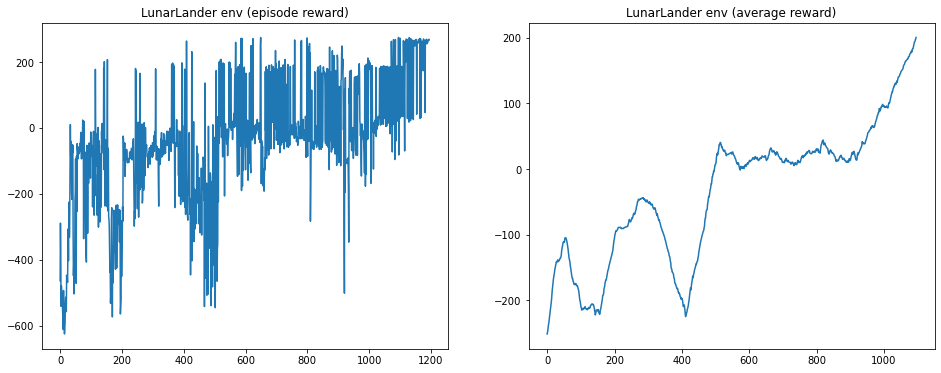

In [68]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(16, 6))
ax1.plot(rew1)
ax1.set_title("LunarLander env (episode reward)")
ax2.plot(avg1)
ax2.set_title("LunarLander env (average reward)")

In [69]:
torch.save(actor, "./model_weight/actor")

## Enviorment 2: 
Suppose there is another planent and his gravity is twice that of the moon, so each time we use a main engine or a side engine, it will has half effect in y-direcion compared to moon.

In [48]:
random_seed = 42
torch.manual_seed(random_seed)

env_wind = env.LunarLander(gravity=-5.0, enable_wind=True, wind_power = 15.0)

In [51]:
actor_wind = Actor()
critic_wind = Critic()

agent_env2 = ActorCritic(actor_wind, critic_wind)

lr = 0.02
betas = (0.9, 0.999)
optimizer = optim.Adam(agent_env2.parameters(), lr=lr, betas=betas)

rew_env2, avg_env2 = train(env_wind, agent_env2, optimizer, episodes = 2500)

C:\Users\55366\AppData\Local\Temp\ipykernel_54960\647289630.py:65: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.smooth_l1_loss(value, reward)


e: 100, episode reward: -314.13, avg reward -183.64
e: 200, episode reward: -89.80, avg reward -134.33
e: 300, episode reward: -174.81, avg reward -152.34
e: 400, episode reward: -50.28, avg reward -122.43
e: 500, episode reward: -77.93, avg reward -159.37
e: 600, episode reward: -110.64, avg reward -98.56
e: 700, episode reward: -28.85, avg reward -59.75
e: 800, episode reward: -13.57, avg reward -52.55
e: 900, episode reward: -17.72, avg reward 20.20
e: 1000, episode reward: 227.66, avg reward 86.49
e: 1100, episode reward: -47.62, avg reward 21.15
e: 1200, episode reward: 139.77, avg reward 34.03
e: 1300, episode reward: 205.52, avg reward 98.54
e: 1400, episode reward: 8.90, avg reward 91.97
e: 1500, episode reward: 217.63, avg reward 46.50
e: 1600, episode reward: 271.04, avg reward 150.09
e: 1700, episode reward: -35.72, avg reward 158.68
Solved on episode  1760


Text(0.5, 1.0, 'Wind (average reward)')

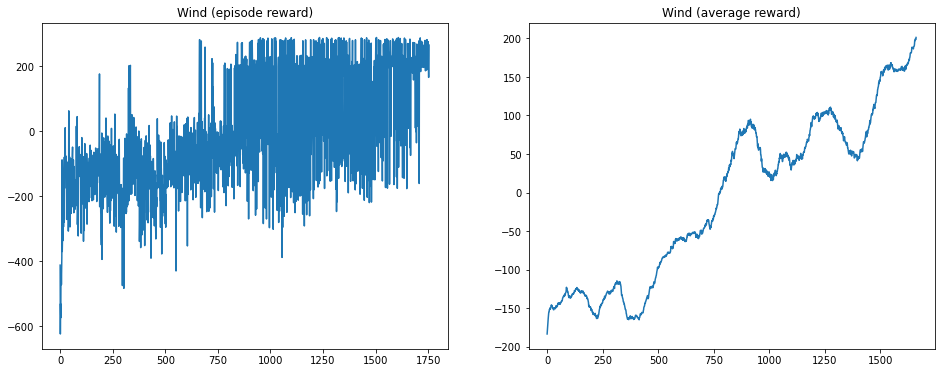

In [54]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(16, 6))

ax1.plot(rew_env2)
ax1.set_title("Wind (episode reward)")
ax2.plot(avg_env2)
ax2.set_title("Wind (average reward)")

In [53]:
torch.save(actor_wind, "./model_weight/actor_wind")

## Train on second enviorment using first enviorment's weight

In [30]:
agent_combined = ActorCritic(actor, critic)

rew3, avg3 = train(env_wind, agent_combined, optimizer, episodes = 2000)

C:\Users\55366\AppData\Local\Temp\ipykernel_54960\647289630.py:65: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.smooth_l1_loss(value, reward)


e: 100, episode reward: -191.22, avg reward -26.77
e: 200, episode reward: -144.34, avg reward -22.02
e: 300, episode reward: -69.98, avg reward -50.96
e: 400, episode reward: -255.68, avg reward -3.68
e: 500, episode reward: 205.32, avg reward -2.13
e: 600, episode reward: 317.61, avg reward -25.76
e: 700, episode reward: -259.18, avg reward -28.33
e: 800, episode reward: -141.06, avg reward -43.90
e: 900, episode reward: -117.29, avg reward -23.20
e: 1000, episode reward: 172.41, avg reward 6.33
e: 1100, episode reward: 195.96, avg reward -0.17
e: 1200, episode reward: 110.04, avg reward -26.51
e: 1300, episode reward: -107.33, avg reward -34.01
e: 1400, episode reward: -185.49, avg reward -23.87
e: 1500, episode reward: -43.94, avg reward -5.39
e: 1600, episode reward: 36.09, avg reward -27.70
e: 1700, episode reward: -217.18, avg reward 6.68
e: 1800, episode reward: 308.82, avg reward -19.74
e: 1900, episode reward: 249.32, avg reward -14.30


Text(0.5, 1.0, "Use env1's weight on env2 (average reward)")

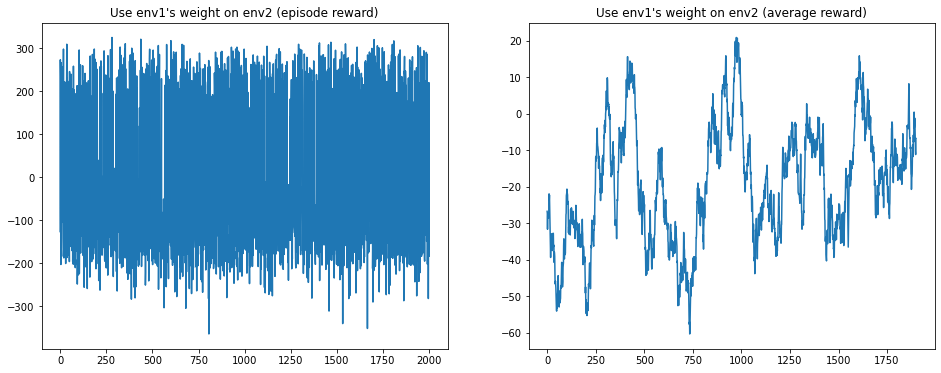

In [31]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(16, 6))

ax1.plot(rew3)
ax1.set_title("Use env1's weight on env2 (episode reward)")

ax2.plot(avg3)
ax2.set_title("Use env1's weight on env2 (average reward)")

## Domain Transfer

In [99]:
class TNet(nn.Module):
    def __init__(self, teacher_1, teacher_2):
        super(TNet, self).__init__()
        self.t1 = teacher_1
        self.t2 = teacher_2

        self.affine = nn.Linear(256, 128)
        self.action_layer = nn.Linear(128, 4)
        self.value_layer = nn.Linear(128, 1)

        self.logprobs = []
        self.state_values = []
        self.rewards = []

    def forward(self, state):
        output_1, distribution_1 = self.t1(state)
        output_2, distribution_2 = self.t2(state)

        out = torch.cat((output_1, output_2))
        
        state = self.affine(out)

        action_prob = F.softmax(self.action_layer(state), dim=-1)
        state_value =  self.value_layer(state)

        distribution = Categorical(action_prob)
        action = distribution.sample()

        self.logprobs.append(distribution.log_prob(action))
        self.state_values.append(state_value)

        return action.item()
    
    def calculateLoss(self, gamma=0.99):
        
        # calculating discounted rewards:
        rewards = []
        dis_reward = 0
        for reward in self.rewards[::-1]:
            dis_reward = reward + gamma * dis_reward
            rewards.insert(0, dis_reward)
                
        # normalizing the rewards:
        rewards = torch.tensor(rewards)
        rewards = (rewards - rewards.mean()) / (rewards.std())
        
        loss = 0
        for logprob, value, reward in zip(self.logprobs, self.state_values, rewards):
            advantage = reward  - value.item()
            action_loss = -logprob * advantage
            value_loss = F.smooth_l1_loss(value, reward)
            loss += (action_loss + value_loss)   
        return loss
    
    def clearMemory(self):
        del self.logprobs[:]
        del self.state_values[:]
        del self.rewards[:]

In [100]:
def train_mutitask(env_1, env_2, agent, optimizer, episodes = 5000, gamma = 0.99, is_render = False):
    avg_rewards_env_1,  episode_rewards_env_1= [], []
    avg_rewards_env_2,  episode_rewards_env_2= [], []

    for episode in  range(episodes):
        state = env_1.reset(seed = 42)
        total_reward = 0

        for i in range(10000):
            if cuda: state = torch.FloatTensor(state).to(device)
            action = agent(state)
            state, reward, done, _ = env_1.step(action)
            agent.rewards.append(reward)
            total_reward += reward
            if is_render and episode % 1000 == 0:
                env_1.render()
            if done:
                episode_rewards_env_1.append(total_reward)
                break
        
        # Updating the policy :
        optimizer.zero_grad()
        loss = agent.calculateLoss(gamma)
        loss.backward()
        optimizer.step()
        agent.clearMemory()
        
        '''for i in range (10000):
            if cuda: state = torch.FloatTensor(state).to(device)
            action = agent(state)
            state, reward, done, _ = env_2.step(action)
            agent.rewards.append(reward)
            total_reward += reward
            if is_render and episode % 1000 == 0:
                env_2.render()
            if done:
                episode_rewards_env_2.append(total_reward)
                break

        # Updating the policy :
        optimizer.zero_grad()
        loss = agent.calculateLoss(gamma)
        loss.backward()
        optimizer.step()
        agent.clearMemory()'''
        
        if episode >= 100:
          avg_rewards_env_1.append(np.mean(episode_rewards_env_1[-100:]))
          # avg_rewards_env_2.append(np.mean(episode_rewards_env_2[-100:]))


        if episode % 100 == 0 and episode >= 100:
            print("e: %d, episode env_1: %.2f, avg env_1: %.2f" % (episode, episode_rewards_env_1[-1], avg_rewards_env_1[-1]))
            # print("e: %d, episode env_1: %.2f, avg env_1: %.2f, episode env_2: %.2f, avg env_2: %.2f" % (episode, episode_rewards_env_1[-1], avg_rewards_env_1[-1], episode_rewards_env_2[-1], avg_rewards_env_2[-1]))

    return episode_rewards_env_1, avg_rewards_env_1,  episode_rewards_env_2, avg_rewards_env_2

In [101]:
actor = torch.load('./model_weight/actor')
actor_wind = torch.load('./model_weight/actor_wind')

agent4 = TNet(actor, actor_wind)

lr = 0.02
betas = (0.9, 0.999)
optimizer = optim.Adam(agent_env2.parameters(), lr=lr, betas=betas)

ep_env1, avg_env_1, ep_env2, avg_env2 = train_mutitask(enviorment,env_wind, agent4, optimizer, episodes = 5000)

C:\Users\55366\AppData\Local\Temp\ipykernel_54960\3057965223.py:51: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.smooth_l1_loss(value, reward)


e: 100, episode env_1: -101.02, avg env_1: -160.10
e: 200, episode env_1: -121.07, avg env_1: -168.00
e: 300, episode env_1: 7.40, avg env_1: -161.51
e: 400, episode env_1: -228.35, avg env_1: -168.91
e: 500, episode env_1: -299.24, avg env_1: -169.25
e: 600, episode env_1: -126.08, avg env_1: -168.14
e: 700, episode env_1: -92.12, avg env_1: -171.69
e: 800, episode env_1: -113.86, avg env_1: -159.67
e: 900, episode env_1: -189.05, avg env_1: -187.85
e: 1000, episode env_1: -97.07, avg env_1: -170.11
e: 1100, episode env_1: -296.83, avg env_1: -168.18
e: 1200, episode env_1: -340.77, avg env_1: -172.35
e: 1300, episode env_1: 25.13, avg env_1: -164.79
e: 1400, episode env_1: -298.66, avg env_1: -156.66
e: 1500, episode env_1: -142.56, avg env_1: -163.21
e: 1600, episode env_1: -358.20, avg env_1: -164.17
e: 1700, episode env_1: -6.49, avg env_1: -166.85
e: 1800, episode env_1: -123.37, avg env_1: -163.03
e: 1900, episode env_1: -110.53, avg env_1: -167.32
e: 2000, episode env_1: -268.1

Text(0.5, 1.0, "Use env1's weight on env2 (average reward)")

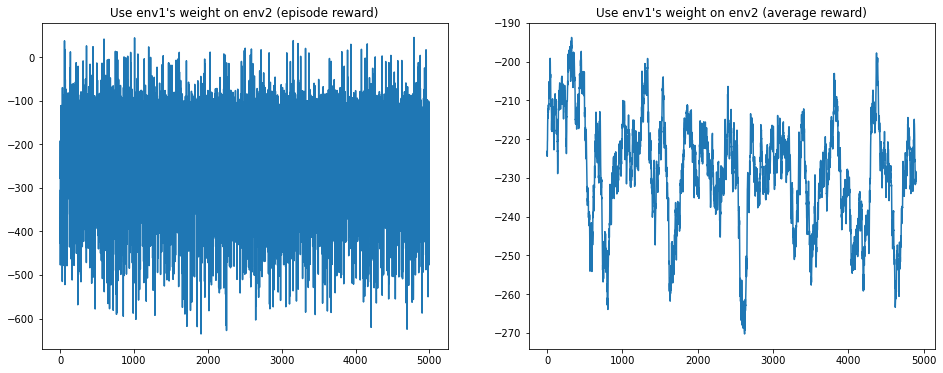

In [76]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(16, 6))

ax1.plot(ep_env1)
ax1.set_title("Use env1's weight on env2 (episode reward)")

ax2.plot(avg_env_1)
ax2.set_title("Use env1's weight on env2 (average reward)")

In [77]:
class TNetv2(nn.Module):
    def __init__(self, teacher_1, teacher_2):
        super(TNet, self).__init__()
        self.t1 = teacher_1
        self.t2 = teacher_2

        self.affine = nn.Linear(256, 128)
        self.action_layer = nn.Linear(256, 4)
        self.value_layer = nn.Linear(256, 1)

        self.logprobs = []
        self.state_values = []
        self.rewards = []

    def forward(self, state):
        output_1, _ = self.t1(state)
        output_2, _ = self.t2(state)

        out = torch.cat((output_1, output_2))

        state = F.relu(out)

        action_prob = F.softmax(self.action_layer(state), dim=-1)
        state_value =  self.value_layer(state)

        distribution = Categorical(action_prob)
        action = distribution.sample()

        self.logprobs.append(distribution.log_prob(action))
        self.state_values.append(state_value)

        return action.item()
    
    def calculateLoss(self, gamma=0.99):
        
        # calculating discounted rewards:
        rewards = []
        dis_reward = 0
        for reward in self.rewards[::-1]:
            dis_reward = reward + gamma * dis_reward
            rewards.insert(0, dis_reward)
                
        # normalizing the rewards:
        rewards = torch.tensor(rewards)
        rewards = (rewards - rewards.mean()) / (rewards.std())
        
        loss = 0
        for logprob, value, reward in zip(self.logprobs, self.state_values, rewards):
            advantage = reward  - value.item()
            action_loss = -logprob * advantage
            value_loss = F.smooth_l1_loss(value, reward)
            loss += (action_loss + value_loss)   
        return loss
    
    def clearMemory(self):
        del self.logprobs[:]
        del self.state_values[:]
        del self.rewards[:]

In [78]:
actor = torch.load('./model_weight/actor')
actor_wind = torch.load('./model_weight/actor_wind')

In [79]:
agent5 = TNet(actor, actor_wind)

lr = 0.02
betas = (0.9, 0.999)
optimizer = optim.Adam(agent_env2.parameters(), lr=lr, betas=betas)

ep_env_5, avg_env_5, ep_env_6, avg_env_6 = train_mutitask(enviorment,env_wind, agent4, optimizer, episodes = 5000)

C:\Users\55366\AppData\Local\Temp\ipykernel_54960\3045748259.py:51: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.smooth_l1_loss(value, reward)


e: 100, episode env_1: -130.58, avg env_1: -217.02, episode env_2: -230.58, avg env_2: -317.02
e: 200, episode env_1: -206.44, avg env_1: -211.42, episode env_2: -306.44, avg env_2: -311.42
e: 300, episode env_1: -345.70, avg env_1: -222.79, episode env_2: -445.70, avg env_2: -322.79
e: 400, episode env_1: -140.81, avg env_1: -224.81, episode env_2: -240.81, avg env_2: -324.81
e: 500, episode env_1: -490.92, avg env_1: -231.38, episode env_2: -590.92, avg env_2: -331.38
e: 600, episode env_1: -450.67, avg env_1: -216.42, episode env_2: -550.67, avg env_2: -316.42
e: 700, episode env_1: -104.40, avg env_1: -230.28, episode env_2: -204.40, avg env_2: -330.28
e: 800, episode env_1: -272.14, avg env_1: -214.14, episode env_2: -372.14, avg env_2: -314.14
e: 900, episode env_1: -25.14, avg env_1: -221.22, episode env_2: -125.14, avg env_2: -321.22
e: 1000, episode env_1: -354.14, avg env_1: -232.59, episode env_2: -454.14, avg env_2: -332.59
e: 1100, episode env_1: -190.99, avg env_1: -213.3